In [1]:
# importing lib
import os
import pickle
import re
import warnings
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau
from prettytable import PrettyTable

2024-04-11 20:52:37.519191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.filterwarnings('ignore')

In [4]:
# loading dataset
dataset = pd.read_csv('./New_York_Airbnb.csv')

In [5]:
# displaying top-5 rows and properties of the dataset
print("Top-5 rows of the dataset")
display(dataset.head())

Top-5 rows of the dataset


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,48,2019-11-04,0.33,3,338,0,NaN
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Bedford-Stuyvesant,40.68494,-73.95765,Entire home/apt,75,1,409,2021-10-22,4.86,1,194,32,NaN
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2016-06-05,0.52,2,365,0,NaN
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,5,2,2021-08-08,0.02,1,123,1,NaN
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,507,2021-11-08,3.68,1,192,33,NaN


In [6]:
row, col = dataset.shape
print(f"The number of rows and columns in the dataset: {row} and {col}")

The number of rows and columns in the dataset: 38277 and 18


In [7]:
print('Descriptive analysis of the dataset')
display(dataset.describe())

Descriptive analysis of the dataset


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.827700e+04,3.827700e+04,38277.000000,38277.000000,38277.000000,38277.000000,38277.000000,28773.000000,38277.000000,38277.000000,38277.000000
mean,2.962239e+07,1.148305e+08,40.729206,-73.948967,170.858714,21.623769,23.302871,1.721019,17.747655,134.290984,5.032160
std,1.742239e+07,1.299194e+08,0.055752,0.050759,305.100271,29.573333,50.415484,4.399826,59.150451,143.196175,14.693768
min,2.595000e+03,2.438000e+03,40.504560,-74.249840,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.341048e+07,1.139462e+07,40.689260,-73.983270,70.000000,3.000000,1.000000,0.120000,1.000000,0.000000,0.000000
50%,3.081269e+07,5.005297e+07,40.725180,-73.954770,114.000000,30.000000,4.000000,0.480000,1.000000,73.000000,0.000000
75%,4.642855e+07,2.002395e+08,40.762680,-73.930430,189.000000,30.000000,20.000000,1.780000,3.000000,302.000000,3.000000
max,5.366510e+07,4.344080e+08,40.914020,-73.710870,10000.000000,1250.000000,1009.000000,141.000000,421.000000,365.000000,669.000000


In [8]:
print(f'Columns in the datasets are : {list(dataset.columns)}')

Columns in the datasets are : ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']


In [9]:
# preprocessing datasets
# checking for the missing values
preprocessDataframe = dataset.isnull().sum(axis=0).reset_index()
preprocessDataframe.columns = ['column', 'count']
preprocessDataframe = preprocessDataframe.loc[preprocessDataframe['count'] > 0].sort_values(by='count')
print('Displaying columns with number of count')
display(preprocessDataframe)

Displaying columns with number of count


,column,count
1,name,13
3,host_name,34
12,last_review,9504
13,reviews_per_month,9504
17,license,38276


In [10]:
# dropping unwanted columns
dataset.drop(['host_name','name','host_id','id','license','number_of_reviews_ltm'], axis=1, inplace=True)

In [11]:
dataset['last_review'] = pd.to_datetime(dataset['last_review'],infer_datetime_format=True) 

In [12]:
# filling dataframe
dataset['reviews_per_month'] = dataset['reviews_per_month'].fillna(0)
earliest = min(dataset['last_review'])
dataset['last_review'] = dataset['last_review'].fillna(earliest)
dataset['last_review'] = dataset['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [13]:
# checking for the missing values post preprocessing
print('\nDisplaying columns with number of count post preprocessing')
display(dataset.isna().any())


Displaying columns with number of count post preprocessing


neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [14]:
# dataset post preprocessing
dataset.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,48,3240,0.33,3,338
1,Brooklyn,Bedford-Stuyvesant,40.68494,-73.95765,Entire home/apt,75,1,409,3958,4.86,1,194
2,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,1993,0.52,2,365
3,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,5,2,3883,0.02,1,123
4,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,507,3975,3.68,1,192


Text(0.5, 0, 'log(1+price)')

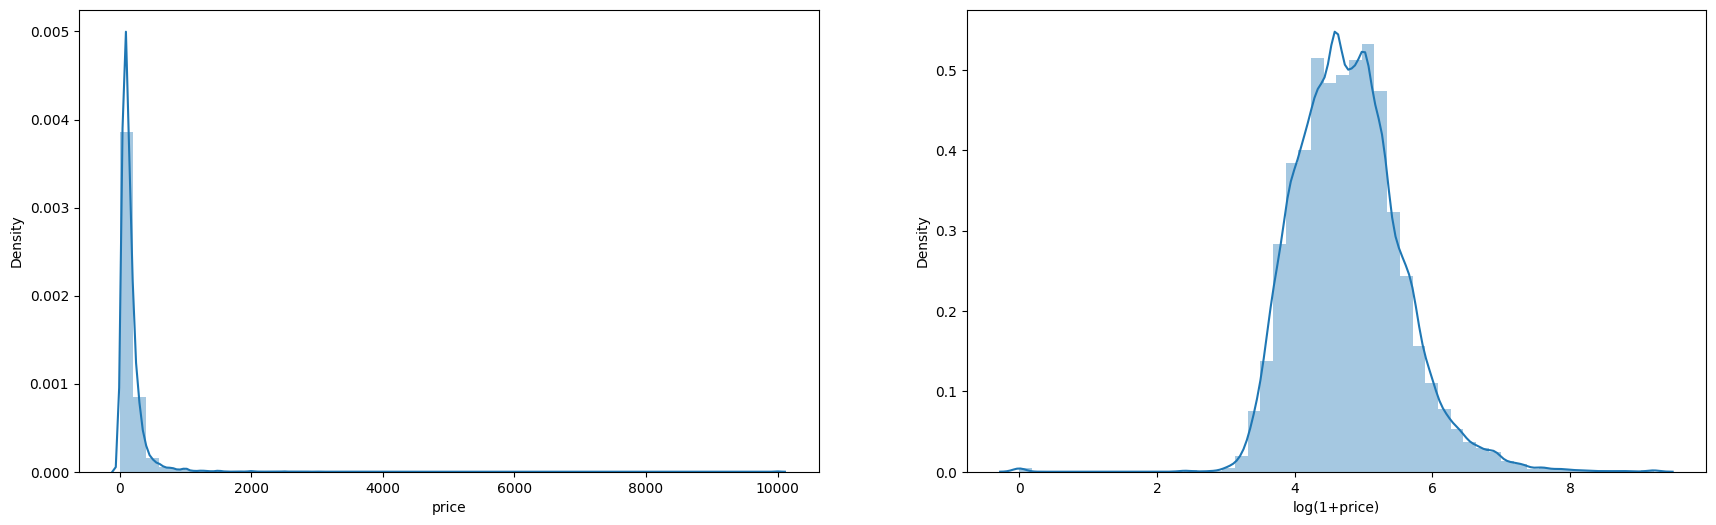

In [15]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(dataset['price'], ax=axes[0])
sns.distplot(np.log1p(dataset['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

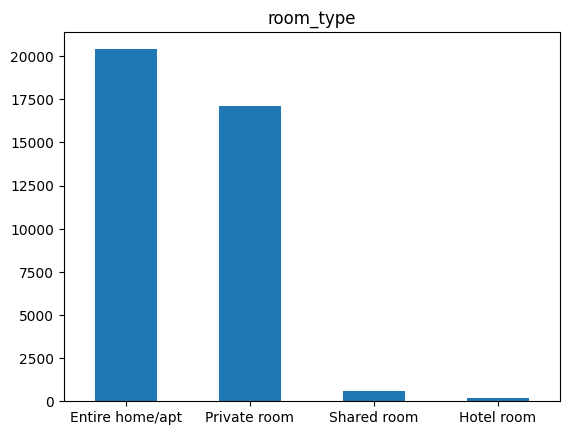

In [16]:
dataset['room_type'].value_counts().plot(kind='bar')
plt.title('room_type')
plt.xticks(rotation=0)
plt.show()

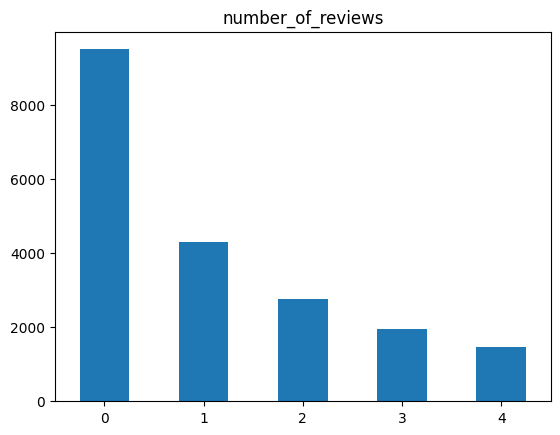

In [17]:
dataset['number_of_reviews'].value_counts().nlargest(5).plot(kind='bar')
plt.title('number_of_reviews')
plt.xticks(rotation=0)
plt.show()


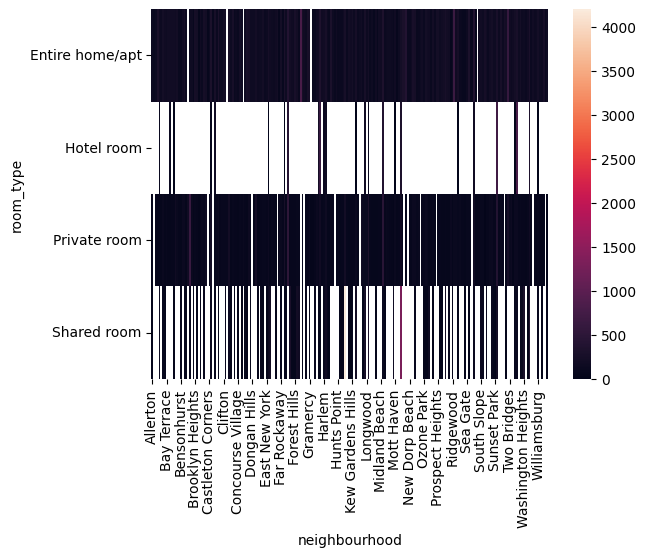

In [18]:
# correlation of the dataset
sns.heatmap(dataset.pivot_table(values='price', index='room_type', columns='neighbourhood'))
plt.show()

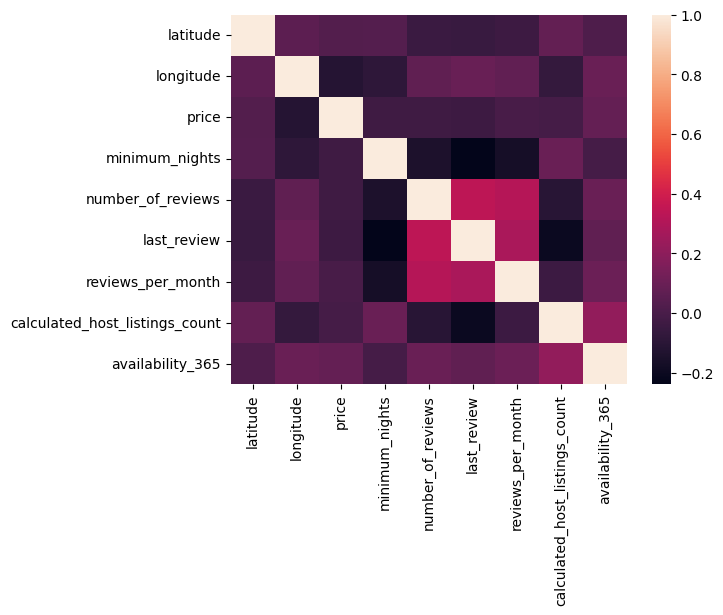

In [19]:
# correlation of the dataset
sns.heatmap(dataset.corr())
plt.show()

In [20]:
categorical_features = dataset.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (38277, 3)


In [21]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
numerical_features =  dataset.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (38277, 8)


In [23]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [24]:
Processed_data = pd.concat([df, y], axis = 1)
Processed_data.to_csv('NYC_Airbnb_Processed.csv')

In [25]:
Processed_data.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price
0,40.75356,-73.98559,30,48,3240,0.33,3,338,0,0,...,0,0,0,0,0,1,0,0,0,150
1,40.68494,-73.95765,1,409,3958,4.86,1,194,0,1,...,0,0,0,0,0,1,0,0,0,75
2,40.68535,-73.95512,30,50,1993,0.52,2,365,0,1,...,0,0,0,0,0,0,0,1,0,60
3,40.66265,-73.99454,5,2,3883,0.02,1,123,0,1,...,0,0,0,0,0,1,0,0,0,275
4,40.76457,-73.98317,2,507,3975,3.68,1,192,0,0,...,0,0,0,0,0,0,0,1,0,68


In [26]:
# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

print(f"The shapes of the train dataset is {X_train.shape}")
print(f"The shapes of the test dataset is {X_test.shape}")


The shapes of the train dataset is (28707, 239)
The shapes of the test dataset is (9570, 239)


In [27]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [28]:
def result_matric(Algo_name,y_pred_train,y_pred_test,y_train=y_train,y_test=y_test):
    result = pd.DataFrame({'Algorithm': [Algo_name],
                  'Mean absolute error (MAE) : Train' : [mean_absolute_error(y_pred_train, y_train)],
                  'Root mean squared error (RMSE) : Train' : np.sqrt([mean_squared_error(y_pred_train, y_train)]),
                  'R-square score (R^2) : Train' : [r2_score(y_pred_train, y_train)],
                  'Mean absolute error (MAE) : Test' : [mean_absolute_error(y_pred_test,y_test)],
                  'Root mean squared error (RMSE) : Test' : np.sqrt([mean_squared_error(y_pred_test,y_test)]),
                  'R-square score (R^2) : Test' : [r2_score(y_pred_test,y_test)]
                })
    return result    

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [30]:
# defining the model
units = 64
model = Sequential()
model.add(
    Bidirectional(LSTM(units=units, return_sequences=True),
                  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=units)))
model.add(Dense(1))
# Compile model
model.compile(loss='mse', optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 128)            155648    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 254593 (994.50 KB)
Trainable params: 254593 (994.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
718/718 [==============================] - 9s 5ms/step - loss: 118027.5469 - val_loss: 78239.1172
Epoch 2/100
718/718 [==============================] - 3s 4ms/step - loss: 106255.7266 - val_loss: 71205.9375
Epoch 3/100
718/718 [==============================] - 3s 4ms/step - loss: 100990.8594 - val_loss: 67096.9297
Epoch 4/100
718/718 [==============================] - 3s 4ms/step - loss: 98078.0781 - val_loss: 65009.3750
Epoch 5/100
718/718 [==============================] - 3s 4ms/step - loss: 96439.9844 - val_loss: 63794.0508
Epoch 6/100
718/718 [==============================] - 3s 4ms/step - loss: 95466.2734 - val_loss: 63022.5391
Epoch 7/100
718/718 [==============================] - 4s 5ms/step - loss: 94729.9688 - val_loss: 62410.5781
Epoch 8/100
718/718 [==============================] - 3s 5ms/step - loss: 94106.0547 - val_loss: 61875.0156
Epoch 9/100
718/718 [==============================] - 3s 4ms/step - loss: 93442.3438 - val_loss: 61254.3359
Epoch 10/100
718

22965/22965 [==============================] - 5s 228us/sample - loss: 61841.0574 - val_loss: 57678.1644
Epoch 137/200
22965/22965 [==============================] - 6s 240us/sample - loss: 61595.2160 - val_loss: 58624.5964
Epoch 138/200
22965/22965 [==============================] - 6s 255us/sample - loss: 61415.1547 - val_loss: 58549.7331
Epoch 139/200
22965/22965 [==============================] - 6s 261us/sample - loss: 61272.9808 - val_loss: 59522.9321
Epoch 140/200
22965/22965 [==============================] - 6s 245us/sample - loss: 61672.9923 - val_loss: 59538.3847
Epoch 141/200
22965/22965 [==============================] - 7s 284us/sample - loss: 60700.2794 - val_loss: 60164.7858
Epoch 142/200
22965/22965 [==============================] - 5s 225us/sample - loss: 60432.9968 - val_loss: 58463.8936
Epoch 143/200
22965/22965 [==============================] - 5s 227us/sample - loss: 60320.2149 - val_loss: 59986.6869
Epoch 144/200
22965/22965 [==============================] - 5

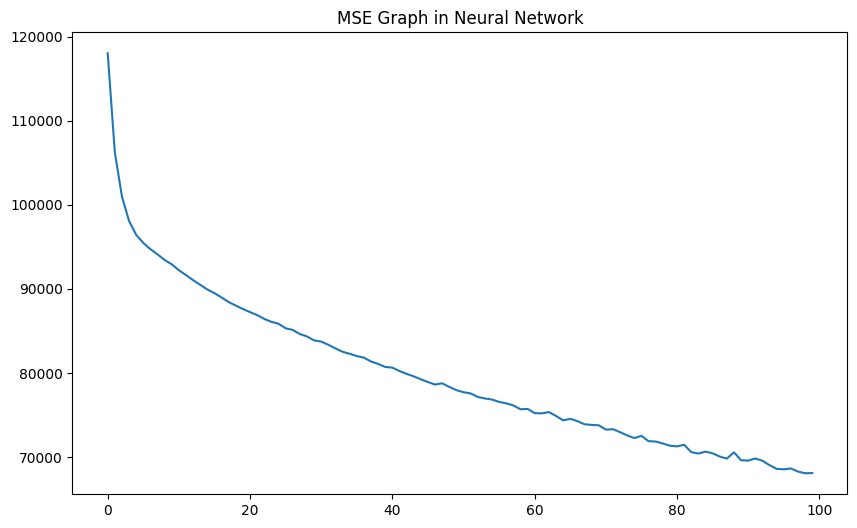

In [33]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(10, 6))
plt.plot(hist.loss)
plt.title("MSE Graph in Neural Network")
plt.show()

In [34]:
y_train_nn = model.predict(X_train) # Y of NN train
y_test_nn = model.predict(X_test) # Y of NN test

mse_nn = mean_squared_error(y_test, y_test_nn)
mae_nn = mean_absolute_error(y_test, y_test_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_test_nn)

print("Mean Squared Error: {}".format(mse_nn))
print("Mean Absolute Error: {}".format(mae_nn))
print("Root Mean Absolute Error: {}".format(rmse_nn))
print("R2 score: {}".format(r2_nn))

300/300 [==============================] - 1s 2ms/step
Mean Squared Error: 76194.55201394012
Mean Absolute Error: 85.9720279764855
Root Mean Absolute Error: 276.03360667487595
R2 score: 0.10877285956941496


In [35]:
result_matric("Bi-LSTM",y_train_nn,y_test_nn)

,Algorithm,Mean absolute error (MAE) : Train,Root mean squared error (RMSE) : Train,R-square score (R^2) : Train,Mean absolute error (MAE) : Test,Root mean squared error (RMSE) : Test,R-square score (R^2) : Test
0,Bi-LSTM,66.812133,255.665091,-2.258612,85.972028,276.033607,-2.583145
